In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy import optimize as opt

import pandas as pd
import xarray as xr

import netCDF4 as nc4

import shutil
import datetime
import subprocess

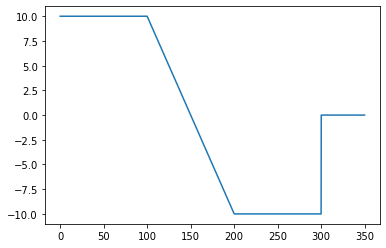

In [2]:
t = np.arange(350 * 12) / 12.
y = np.zeros(350 * 12) * 1.
y[0:1200] = 10.
y[1200:2400] = 10. - (0.2 *  np.arange(100*12)/12.)
y[2400:3601] = -10.


yy = y.cumsum()/12.

plt.plot(t,y)



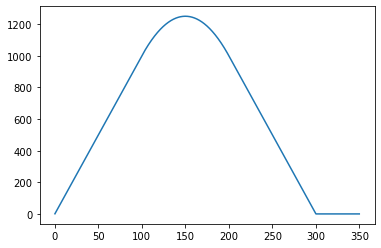

In [3]:
plt.plot(t,yy)

In [4]:
yy

array([0.83333333, 1.66666667, 2.5       , ..., 0.        , 0.        ,
       0.        ])

In [5]:
mapfile = xr.open_dataset('areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
areas = mapfile['areacella'].sum()
global_gridcell_integrated_area = float(areas.data)

/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [6]:
fname_base = 'emissions_idealized_edrivencdr_000101-031012_fv_0.9x1.25_cdk_20220215.nc'

datestring = str(datetime.date.today().year * 10000 + datetime.date.today().month * 100 + datetime.date.today().day)
fname_new = 'emissions_idealized_flat10_reversal_cdk_'+datestring+'.nc'

shutil.copyfile(fname_base, fname_new)

'emissions_idealized_flat10_reversal_cdk_20230808.nc'

In [7]:
file = nc4.Dataset(fname_new, 'r+')


In [8]:
time_firstyear = file.variables['time'][0:12]
time_bnds_firstyear = file.variables['time_bnds'][0:12,:]

In [9]:
nyears_out = 350
ts_out = nyears_out * 12
year_out = np.floor(np.arange(ts_out) / 12)
month_out = np.tile(time_firstyear,nyears_out)
date_out = year_out*365 + month_out

In [10]:
month_out_bnds = np.tile(time_bnds_firstyear,(nyears_out,1))
#month_out_bnds.shape
date_out_bnds = np.tile(year_out, (2,1)).transpose()*365 + month_out_bnds


In [11]:
file.variables['time'][:] = date_out

In [12]:
file.variables['time_bnds'][:] = date_out_bnds

In [13]:
#file.variables['CO2_flux']

In [14]:
t = date_out / 365.

In [15]:
IM = len(file.variables['lon'][:])
JM = len(file.variables['lat'][:])


In [16]:
co2fluxdata = np.tile(y * 1.e12 * (44.01/12.01) / (global_gridcell_integrated_area * 86400. * 365.), (IM,JM,1))  # IM,JM))

In [17]:
co2fluxdata.transpose().shape

(4200, 192, 288)

In [18]:
file.variables['CO2_flux'][:].shape

(4200, 192, 288)

In [19]:
file.variables['CO2_flux'][:] = co2fluxdata.transpose()

In [20]:
file.variables['time'].units = 'days since 0001-01-01 00:00:00'

In [21]:
file.data_title = "Idealized emissions-driven CDR experiment, delta T = 300 years, max cumulative emissions = 1000 Pg C." ;
file.data_summary = "idealized data is output of function y = gaussderiv(t,a=1004,b=150,c=45), where gaussderiv function is y = (a*(b-t)*np.exp(-((b-t)**2.)/(2*c**2.)))/(c**2.). Peak value of 1004 Pg rather than 1000 Pg used to compensate for truncated tails."
file.source_files = "netcdf template from emissions-cmip6_CO2_anthro_surface_175001-201512_fv_0.9x1.25_c20181011.nc. script for generating is on https://github.com/ckoven/idealized_emissionsdriven_cdr_scenario. gridcell areas from areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc"
file.data_creator = "charlie koven, cdkoven@lbl.gov"
file.creation_date = datetime.date.today().isoformat()
file.data_script = "make_idealized_edriven_scenario_forcingfile.ipynb"
file.data_reference = "n/a"

In [22]:
file.close()

In [23]:
y.cumsum()[-1]

0.0

In [24]:
y.cumsum().argmax()

1799

In [25]:
y.argmax()

0

In [26]:
#genarate a hash of the output file in case future verification is needed
subprocess.run(['md5', fname_new], stdout=subprocess.PIPE)


CompletedProcess(args=['md5', 'emissions_idealized_flat10_reversal_cdk_20230808.nc'], returncode=0, stdout=b'MD5 (emissions_idealized_flat10_reversal_cdk_20230808.nc) = 98c51bc3b454f8d2e7491e325d42b0e0\n')

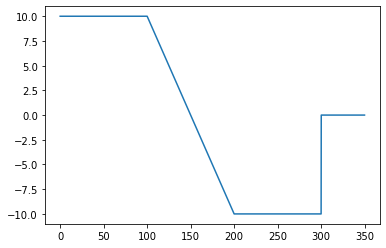

In [27]:
plt.plot(t,y)
